# Utilización de Python para recolectar y obtener datos de Twitter

El objetivo de esta tarea consistirá en recolectar tweets de una temática de interés y almacenarlos en un fichero para su posterior análisis. Los pasos a realizar son los siguientes:

1. Acceder a la web de desarrolladores de Twitter y crear una cuenta y aplicación. Guardar claves (consumer_key, consumer_secret, token y secret).
2. Utilizando estas claves y la librería tweepy, invocar un comando para escuchar tweets incluyendo algún tema que te resulte de interés (ransomware, wannacry, o similar).
3. Almacenar estos tweets en un fichero, utilizando el formato que prefieras.
4. Crear un dataframe con pandas con las siguientes columnas: usuario del tweet, texto del tweet, fecha de creación, localización, número de palabras del texto y número de caracteres del tweet (estos dos últimos campos deberás calcularlos a partir del texto del tweet).
5. Añadir una columna al dataframe que refleje la hora del tweet (P.ej. Si el tweet tiene la fecha u'Mon May 23 14:46:46 +0000 2016' vamos a convertirlo a 14). Llamar a este nuevo campo hora.
6. Agregar al dataframe por el campo hora y mostrar por pantalla el número de tweets por hora.

## 1. Recolección de datos

Para acceder a la API de Twitter y obtener sus datos utilizaremos la librería [Tweepy](https://tweepy.readthedocs.io/en/latest/index.html). Una vez instalada, importaremos Tweepy y el resto de librerías necesarias y configuraremos nuestras credenciales de acceso a la API de Twitter.

In [1]:
# Import libraries
import tweepy
import json
import os, sys
import csv
import time

# Variables that contains the user credentials to access Twitter API
consumer_key="*********"
consumer_secret="*********"
token="*********"
secret="*********"

# Set access API
auth=tweepy.OAuthHandler(consumer_key,consumer_secret)
auth.set_access_token(token,secret) 

Comprobamos que nos conectamos a la API de Twitter analizando las tendencias globales. Esta información nos servirá para recopilar un volumen mayor de tweets en menor tiempo sobre una temática popular.

Para ello se utilizará el método [`trends_place`](http://docs.tweepy.org/en/v3.8.0/api.html#API.trends_place) de la librería Tweepy que nos devuelve la información en un array en formato JSON con las 50 tendencias de un lugar.

Para obtener las tendencias de una ubicación específica se debe indicar su identificador `WOEID` (Where On Earth) en el parámetro `id` de `trends_place`. Para tendencias globales el WOEID es **1**. Se puede consultar el WOEID de otras ciudades del mundo en esta [web](https://www.eltitular.es/woeid/).

In [2]:
api=tweepy.API(auth)

worldwide_WOE_ID=1

worldwide_trends=api.trends_place(worldwide_WOE_ID)

trends=json.loads(json.dumps(worldwide_trends, indent=1))

trending_topics=[trend["name"] for trend in trends[0]["trends"]]
 
# Show Top20 Twitter trends for Worldwide   
trending_topics[:20]

['#ImpeachmentDay',
 '#ElClasico',
 '#StarWarsRiseofSkywalker',
 '#SınıfaONBİNhak60binŞart',
 '#HappyYoungKDay',
 'Jean',
 'クロちゃん',
 'Rodrigo Caetano',
 'オリオン',
 '金銭トレード',
 'エウロペ',
 '#1PCpour2020',
 '#安藤誠明君幸せをありがとう',
 '#اجمل_صوره_عندك',
 '#OneItSelcaDay',
 '#amayeter',
 '#intihar',
 '#水曜日のダウンタウン',
 '#FinaleWithIrene',
 '#IndiansAgainstCAA']

El segundo topic más popular en Twitter es el partido de fútbol que se juega hoy (18/12/2019) entre los equipos españoles FC Barcelona y Real Madrid. 

Vamos a recopilar tweets en tiempo real con el hashtag **#ElClasico**. Para ello utilizaremos una interfaz de Twitter denominada *streaming*, que recibe un flujo de actualizaciones de los servidores de Twitter cada vez que se registra un nuevo tweet que coincida con los criterios de búsqueda de nuestra palabra #ElClasico.

Para usar esta función será necesario que implementemos una subclase de la clase `tweepy.streaming.StreamListener`. El objetivo de implementar esta subclase será especificar cómo se comportará nuestro programa cada vez que se reciba un nuevo tweet o cuando ocurra un error.

La clase que definiremos se llamará *MyStreamListener* y se encargará de escribir cada tweet recibido en un archivo en formato JSON.

Así mismo, a nuestra clase se le especificará un número límite de mensajes (si no especificamos un límite, la clase seguirá escribiendo los mensajes hasta que se interrumpa el flujo).

In [3]:
# Create a streamer object
class MyStreamListener(tweepy.StreamListener):
    
    def on_connect(self):
        # Called initially to connect to the Streaming API
        print("You are now connected to the streaming API.")  
  
    def __init__(self, api=None, limit=None):
        super(MyStreamListener, self).__init__()
        
        self.num_tweets=0
        self.limit=limit
        
        # Create a file with 'data_' and the current time
        self.filename = 'data'+'_'+time.strftime('%Y%m%d-%H%M%S')+'.json'
        # Create a new file with that filename
        self.file = open(self.filename, "w")
    
    # When a tweet appears
    def on_status(self, status):
        
        if self.num_tweets < self.limit:
            tweet= status._json
            self.file.write(json.dumps(tweet) + '\n')
            self.num_tweets += 1
            # just to see some progress...
            if self.num_tweets % 10000 == 0:
                print('Number of tweets captured so far: {}'.format(self.num_tweets))      
            # Return nothing
            return
        else:
            print("Tweets limit reached. Finish the stream")
            # End the stream
            return False
        
         # Close the file
        self.file.close()

    # When an error occurs
    def on_error(self, status_code):
        # Print the error code
        print('Encountered error with status code:', status_code)
        
        # If the error code is 401, which is the error for bad credentials
        if status_code == 401:
            # End the stream
            return False
    
    # When timed out    
    def on_timeout(self):
        # Print timeout message
        print(sys.stderr, 'Timeout...')
        # Wait 10 seconds
        time.sleep(10)
        # Return nothing
        return

In [4]:
# Check how long it takes the streaming
%%time

# Initialize Stream listener with a limit of 100000 tweets
myStreamListener= MyStreamListener(limit=100000)

# Create a Stream object with listener and authentication
stream= tweepy.Stream(auth, listener=myStreamListener)

# Filter Twitter Streams to capture data by the keywords:
stream.filter(track=["#ElClasico"])

You are now connected to the streaming API.
Number of tweets captured so far: 10000
Number of tweets captured so far: 20000
Number of tweets captured so far: 30000
Number of tweets captured so far: 40000
Number of tweets captured so far: 50000
Number of tweets captured so far: 60000
Number of tweets captured so far: 70000
Number of tweets captured so far: 80000
Number of tweets captured so far: 90000
Number of tweets captured so far: 100000
Tweets limit reached. Finish the stream
Wall time: 2h 24min 34s


## 2. Preprocesado de datos

Una vez que se han escrito los mensajes en el archivo *data_20191218-181728.json*, es posible leerlos y cargarlos en un DataFrame de Pandas.

Primero, vamos a importar las librerías que utilizaremos para nuestro análisis de datos.

In [1]:
%matplotlib inline

import pandas as pd
import json
import re
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)

Abrimos el archivo y guardamos sus datos en una lista de diccionarios:

In [2]:
# Open connection to file
with open("data_20191218-181728.json") as tweets_file:
    # Read in tweets and store in list
    tweets_data = [json.loads(line) for line in tweets_file.readlines()]

A continuación, convertimos la lista de diccionarios `tweets_data` en un DataFrame y exploramos nuestro dataset:

In [3]:
tweets_df = pd.DataFrame(tweets_data)

# Check rows and columns of the dataset
print(tweets_df.shape) 

# Display the first ten rows
tweets_df.head(10)

(99999, 37)


,contributors,coordinates,created_at,display_text_range,entities,extended_entities,extended_tweet,favorite_count,favorited,filter_level,geo,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,place,possibly_sensitive,quote_count,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,reply_count,retweet_count,retweeted,retweeted_status,source,text,timestamp_ms,truncated,user,withheld_in_countries
0,None,None,Wed Dec 18 17:17:24 +0000 2019,NaN,"{'hashtags': [{'text': 'elclasico', 'indices':...","{'media': [{'id': 1207315042070347778, 'id_str...",NaN,0,False,low,None,1207349153900191746,1207349153900191746,None,NaN,None,NaN,None,False,tr,None,False,0,NaN,NaN,NaN,NaN,0,0,False,{'created_at': 'Wed Dec 18 15:01:53 +0000 2019...,"<a href=""http://twitter.com/download/android"" ...",RT @atavratzlatan: tarafımız belli.. #elclasic...,1576689444409,False,"{'id': 1204632638612557825, 'id_str': '1204632...",NaN
1,None,None,Wed Dec 18 17:17:24 +0000 2019,NaN,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,NaN,0,False,low,None,1207349155271774211,1207349155271774211,None,NaN,None,NaN,None,True,es,None,NaN,0,{'created_at': 'Wed Dec 18 16:59:27 +0000 2019...,1.207345e+18,1207344635930128384,"{'url': 'https://t.co/UIGYQ3wRMt', 'expanded':...",0,0,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...","Se llama tranvía, el metro es subterráneo.",1576689444736,False,"{'id': 186380994, 'id_str': '186380994', 'name...",NaN
2,None,None,Wed Dec 18 17:17:24 +0000 2019,NaN,"{'hashtags': [{'text': 'HalaMadrid', 'indices'...",NaN,NaN,0,False,low,None,1207349155498201088,1207349155498201088,None,NaN,None,NaN,None,True,es,None,NaN,0,{'created_at': 'Wed Dec 18 15:00:01 +0000 2019...,1.207315e+18,1207314579492966400,"{'url': 'https://t.co/O4E4UhJEu2', 'expanded':...",0,0,False,NaN,"<a href=""http://twitter.com/download/android"" ...",A por ellos 💪💪💪 #HalaMadrid,1576689444790,False,"{'id': 1004857484652302338, 'id_str': '1004857...",NaN
3,None,None,Wed Dec 18 17:17:24 +0000 2019,NaN,"{'hashtags': [{'text': 'ElClasico', 'indices':...",NaN,NaN,0,False,low,None,1207349155921891328,1207349155921891328,None,NaN,None,NaN,None,False,en,None,NaN,0,NaN,NaN,NaN,NaN,0,0,False,{'created_at': 'Wed Dec 18 15:32:09 +0000 2019...,"<a href=""http://twitter.com/download/android"" ...",RT @wallexymilla: #ElClasico in few hours...\n...,1576689444891,False,"{'id': 1144168401457356801, 'id_str': '1144168...",NaN
4,None,None,Wed Dec 18 17:17:24 +0000 2019,NaN,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,NaN,0,False,low,None,1207349155980546051,1207349155980546051,None,NaN,None,NaN,None,False,en,None,NaN,0,NaN,NaN,NaN,NaN,0,0,False,{'created_at': 'Wed Dec 18 15:49:13 +0000 2019...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @iamprincegyasi: Barcelona takes el'clasico...,1576689444905,False,"{'id': 528565697, 'id_str': '528565697', 'name...",NaN
5,None,None,Wed Dec 18 17:17:25 +0000 2019,NaN,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,NaN,0,False,low,None,1207349156534243330,1207349156534243330,None,NaN,None,NaN,None,True,ar,None,NaN,0,{'created_at': 'Wed Dec 18 17:14:37 +0000 2019...,1.207348e+18,1207348453258539011,"{'url': 'https://t.co/sOD808xApV', 'expanded':...",0,0,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",دلبي👑,1576689445037,False,"{'id': 579020244, 'id_str': '579020244', 'name...",NaN
6,None,None,Wed Dec 18 17:17:25 +0000 2019,NaN,"{'hashtags': [{'text': 'ElClasico', 'indices':...",NaN,NaN,0,False,low,None,1207349156597161989,1207349156597161989,None,NaN,None,NaN,None,False,en,None,NaN,0,NaN,NaN,NaN,NaN,0,0,False,{'created_at': 'Wed Dec 18 14:30:05 +0000 2019...,"<a href=""http://twitter.com/download/iphone"" r...",RT @hopesolo: Can’t wait to watch the biggest ...,1576689445052,False,"{'id': 621998309, 'id_str': '621998309', 'name...",NaN
7,None,None,Wed Dec 18 17:17:25 +0000 2019,NaN,"

In [4]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 37 columns):
contributors                 0 non-null object
coordinates                  26 non-null object
created_at                   99999 non-null object
display_text_range           9297 non-null object
entities                     99999 non-null object
extended_entities            33155 non-null object
extended_tweet               6824 non-null object
favorite_count               99999 non-null int64
favorited                    99999 non-null bool
filter_level                 99999 non-null object
geo                          26 non-null object
id                           99999 non-null int64
id_str                       99999 non-null object
in_reply_to_screen_name      2209 non-null object
in_reply_to_status_id        1764 non-null float64
in_reply_to_status_id_str    1764 non-null object
in_reply_to_user_id          2209 non-null float64
in_reply_to_user_id_str      2209 non-null

Tras analizar el dataset se deben tener en cuenta las siguientes observaciones:
* Este dataset contiene los datos recopilados en bruto, dependiendo del tipo de análisis muchos campos no serán necesarios.
* Tiene casi 100000 tweets almacenados (filas) y 37 columnas. En la [documentación oficial de Twitter](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object) se puede investigar la descripción de cada columna.
* Los valores de algunas columnas, son diccionarios que contienen varios subcampos con información que nos interesará extraer.
* El texto de algunos tweets aparece truncado ya que superan los 140 caracteres.
* Los tweets están registrados en zona horaria UTC (+00:00), en España se debe añadir una hora más (UTC +1).

En este análisis se pretende responder las siguientes cuestiones:
1. ¿Cuál es el número de palabras y de caracteres de cada tweet?
2. ¿Cuántos tweets se publican por hora?
3. ¿En qué idiomas se publicaron más tweets?
4. ¿Desde qué medio (source) se publicaron más tweets?
5. ¿Cuáles son los hashtags más populares?

Para llevar a cabo nuestro objetivo vamos a crear una copia del dataset original y uno nuevo en el que se irán registrando los datos limpios. Además, para facilitar la limpieza y manipulación de los datos, seleccionaremos únicamente las columnas que utilizaremos en nuestro análisis:

* **id_str**: identificador único para cada tweet. Puede ser útil si queremos comprobar algún mensaje en Twitter escribiendo la url: twitter.com/user_name/status/id
* **created_at**: fecha y hora de publicación del tweet.
* **user**: dicionario que contiene información del usuario. Nos interesa extraer el nombre y la localización.
* **text**: mensaje publicado. Si es superior a 140 caracteres se acorta el mensaje y se añade un link a Twitter para leerlo completamente.
* **truncated**: columna que indica con valor True si el mensaje ha sido recortado al superar los 140 caracteres.
* **extended_tweet**: diccionario que contiene el mensaje completo cuando el tweet supera los 140 caracteres.
* **lang**: idioma en el que se ha publicado un tweet.
* **source**: fuente desde donde se publica el tweet.

In [5]:
# Create copy of original dataset
raw_tweets=tweets_df.copy()

# Create a empty dataset
tidy_tweets=pd.DataFrame()

# Filter columns
tweets_df=tweets_df[["id_str","created_at","user","text","truncated","extended_tweet","lang","source",]]

# Check modified dataset
tweets_df.head(10)

,id_str,created_at,user,text,truncated,extended_tweet,lang,source
0,1207349153900191746,Wed Dec 18 17:17:24 +0000 2019,"{'id': 1204632638612557825, 'id_str': '1204632...",RT @atavratzlatan: tarafımız belli.. #elclasic...,False,NaN,tr,"<a href=""http://twitter.com/download/android"" ..."
1,1207349155271774211,Wed Dec 18 17:17:24 +0000 2019,"{'id': 186380994, 'id_str': '186380994', 'name...","Se llama tranvía, el metro es subterráneo.",False,NaN,es,"<a href=""http://twitter.com/download/iphone"" r..."
2,1207349155498201088,Wed Dec 18 17:17:24 +0000 2019,"{'id': 1004857484652302338, 'id_str': '1004857...",A por ellos 💪💪💪 #HalaMadrid,False,NaN,es,"<a href=""http://twitter.com/download/android"" ..."
3,1207349155921891328,Wed Dec 18 17:17:24 +0000 2019,"{'id': 1144168401457356801, 'id_str': '1144168...",RT @wallexymilla: #ElClasico in few hours...\n...,False,NaN,en,"<a href=""http://twitter.com/download/android"" ..."
4,1207349155980546051,Wed Dec 18 17:17:24 +0000 2019,"{'id': 528565697, 'id_str': '528565697', 'name...",RT @iamprincegyasi: Barcelona takes el'clasico...,False,NaN,en,"<a href=""https://mobile.twitter.com"" rel=""nofo..."
5,1207349156534243330,Wed Dec 18 17:17:25 +0000 2019,"{'id': 579020244, 'id_str': '579020244', 'name...",دلبي👑,False,NaN,ar,"<a href=""http://twitter.com/download/iphone"" r..."
6,1207349156597161989,Wed Dec 18 17:17:25 +0000 2019,"{'id': 621998309, 'id_str': '621998309', 'name...",RT @hopesolo: Can’t wait to watch the biggest ...,False,NaN,en,"<a href=""http://twitter.com/download/iphone"" r..."
7,1207349156890722304,Wed Dec 18 17:17:25 +0000 2019,"{'id': 861934839427190785, 'id_str': '86193483...",RT @partidazocope: 🔵🔴 ÚLTIMA HORA | El @FCBarc...,False,NaN,es,"<a href=""http://twitter.com/download/android"" ..."
8,1207349156983066625,Wed Dec 18 17:17:25 +0000 2019,"{'id': 113494664, 'id_str': '113494664', 'name...",RT @raphaelvarane: Match Day #ElClasico ⚽️⚡️ V...,False,NaN,en,"<a href=""http://twitter.com/download/android"" ..."
9,1207349157477920770,Wed Dec 18 17:17:25 +0000 2019,"{'id': 1124849898501935108, 'id_str': '1124849...",RT @BahisFox: Fox Bahis'ten El Clasico'ya Özel...,False,NaN,tr,"<a href=""http://twitter.com/download/android"" ..."


A continuación, iremos añadiendo los datos limpios al DataFrame nuevo `tidy_tweets`.

Para extraer la fecha y hora de la columna `created_at` primero convertimos sus valores a un objeto *datetime* mediante la función de Pandas *to_datetime()* y añadimos una hora (UTC+1) con la función *Timedelta*.
Posteriormente recuperamos los atributos *date* y *time* mediante el método accessor *dt*.

In [6]:
# Add new column with tweet ID
tidy_tweets["id"]=tweets_df["id_str"]

# Convert to datetime and add 1 hour
tweets_df['created_at']=pd.to_datetime(raw_tweets["created_at"]) + pd.Timedelta('1 hour')

# Add new column with tweet date
tidy_tweets['date']=tweets_df["created_at"].dt.date

# Add new column with tweet time
tidy_tweets['time']=tweets_df["created_at"].dt.time

# Check new columns
tidy_tweets.head()

,id,date,time
0,1207349153900191746,2019-12-18,18:17:24
1,1207349155271774211,2019-12-18,18:17:24
2,1207349155498201088,2019-12-18,18:17:24
3,1207349155921891328,2019-12-18,18:17:24
4,1207349155980546051,2019-12-18,18:17:24


Si consultamos en la [documentación de Twitter](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/user-object) comprobamos que la información de la columna `user` está almacenada en un diccionario que contiene los 2 atributos *screen_name* y *location* que nos interesa añadir a nuestro DataFrame.

In [7]:
tweets_df["user"][0]

{'id': 1204632638612557825,
 'id_str': '1204632638612557825',
 'name': 'Madridista hasta el final',
 'screen_name': 'TioMadridista7',
 'location': 'Madrid, Comunidad de Madrid',
 'url': None,
 'description': 'Hincha del Mejor Club de la Historia y del Mundo actualmente.🏆⚽🇪🇸',
 'translator_type': 'none',
 'protected': False,
 'verified': False,
 'followers_count': 22,
 'friends_count': 63,
 'listed_count': 1,
 'favourites_count': 1029,
 'statuses_count': 728,
 'created_at': 'Wed Dec 11 05:23:13 +0000 2019',
 'utc_offset': None,
 'time_zone': None,
 'geo_enabled': False,
 'lang': None,
 'contributors_enabled': False,
 'is_translator': False,
 'profile_background_color': 'F5F8FA',
 'profile_background_image_url': '',
 'profile_background_image_url_https': '',
 'profile_background_tile': False,
 'profile_link_color': '1DA1F2',
 'profile_sidebar_border_color': 'C0DEED',
 'profile_sidebar_fill_color': 'DDEEF6',
 'profile_text_color': '333333',
 'profile_use_background_image': True,
 'profile

In [8]:
# Add new column with the user's name and location
tidy_tweets['user_name']=tweets_df['user'].apply(lambda u: u["screen_name"])
tidy_tweets['location']=tweets_df['user'].apply(lambda l: l["location"])

# Add language column
tidy_tweets['lang']=tweets_df['lang']

# Check new columns
tidy_tweets.head()

,id,date,time,user_name,location,lang
0,1207349153900191746,2019-12-18,18:17:24,TioMadridista7,"Madrid, Comunidad de Madrid",tr
1,1207349155271774211,2019-12-18,18:17:24,miquellebrel,BCN,es
2,1207349155498201088,2019-12-18,18:17:24,futbolero502,None,es
3,1207349155921891328,2019-12-18,18:17:24,Knust_adaakwa,Koteaboa junction,en
4,1207349155980546051,2019-12-18,18:17:24,djsheylex,Lagos Ogun Oyo,en


En la columna `text` algunos mensajes aparecen recortados y con un link a Twitter para leerlo completamente. Esto sucede cuando el tweet supera los 140 caracteres y se indica con el valor de *True* en la columna `truncated`. 
El mensaje completo se encuentra almacenado dentro de un diccionario en la columna `extended_tweet`.

In [9]:
# Check truncated tweets
tweets_df[tweets_df['truncated']==True]['text'].head()

13    Podrás ser fan o no de alguno de estos 2 equip...
27    Live HD Stream #ElClasico \n\nBarcelona vs Rea...
49    ما توقعاتكم لمباراة الكلاسيكو : برشلونة x ريال...
56    Get quality FOUR CCTVS, Fully packaged kit. WI...
61    The best option for watching the El Clasico li...
Name: text, dtype: object

In [10]:
#short tweet under 140 characters
print(tweets_df['text'][0])

#truncated tweet over 140 characters
print(tweets_df['text'][13])

#extended tweet
print(tweets_df["extended_tweet"][13]["full_text"])

RT @atavratzlatan: tarafımız belli.. #elclasico https://t.co/hMZgrwcHZV
Podrás ser fan o no de alguno de estos 2 equipos, podrás perderte cualquier número de partidos en la temporada, per… https://t.co/Ea5SM9DACs
Podrás ser fan o no de alguno de estos 2 equipos, podrás perderte cualquier número de partidos en la temporada, pero es IMPERDONABLE es perderte #ElClasico 

El #BarcelonaRealMadrid es el mejor partido del MUNDO.


In [11]:
tweets_df['truncated'].sum()/tweets_df.shape[0]

0.06824068240682407

Aunque el número de tweets acortados representa únicamente casi el 7% del total de la muestra, vamos a añadir a nuestro dataset limpio una columna que muestre los mensajes completos ya que nos hará falta para calcular correctamente el nº de palabras y caracteres de cada mensaje.

In [12]:
# Extract the full_text subfield of extended_tweet column
full_tweet=tweets_df["extended_tweet"].apply(lambda tweet: tweet['full_text'] if not pd.isnull(tweet) else np.nan)

# Add new column with the complete tweets
tidy_tweets['text']=tweets_df['text'].mask(tweets_df['truncated'],full_tweet)

# Check new column
tidy_tweets.head()

,id,date,time,user_name,location,lang,text
0,1207349153900191746,2019-12-18,18:17:24,TioMadridista7,"Madrid, Comunidad de Madrid",tr,RT @atavratzlatan: tarafımız belli.. #elclasic...
1,1207349155271774211,2019-12-18,18:17:24,miquellebrel,BCN,es,"Se llama tranvía, el metro es subterráneo."
2,1207349155498201088,2019-12-18,18:17:24,futbolero502,None,es,A por ellos 💪💪💪 #HalaMadrid
3,1207349155921891328,2019-12-18,18:17:24,Knust_adaakwa,Koteaboa junction,en,RT @wallexymilla: #ElClasico in few hours...\n...
4,1207349155980546051,2019-12-18,18:17:24,djsheylex,Lagos Ogun Oyo,en,RT @iamprincegyasi: Barcelona takes el'clasico...


A continuación, vamos añadir 2 columnas que indiquen el nº de caracteres y palabras de cada mensaje:

In [13]:
#Add column with number of words
tidy_tweets['word_count']=tidy_tweets['text'].apply(lambda text: len(re.findall(r'\w+',text)))

#Add column with number of characters
tidy_tweets['char_count']=tidy_tweets['text'].str.len()

Por último, vamos a filtrar y extraer el nombre del cliente de Twitter de la columna `source`:

In [14]:
tidy_tweets['source'] = tweets_df['source'].str.extract('>(.+?)<', expand=False).str.strip()

# Check new columns
tidy_tweets.head(10)

,id,date,time,user_name,location,lang,text,word_count,char_count,source
0,1207349153900191746,2019-12-18,18:17:24,TioMadridista7,"Madrid, Comunidad de Madrid",tr,RT @atavratzlatan: tarafımız belli.. #elclasic...,9,71,Twitter for Android
1,1207349155271774211,2019-12-18,18:17:24,miquellebrel,BCN,es,"Se llama tranvía, el metro es subterráneo.",7,42,Twitter for iPhone
2,1207349155498201088,2019-12-18,18:17:24,futbolero502,None,es,A por ellos 💪💪💪 #HalaMadrid,4,27,Twitter for Android
3,1207349155921891328,2019-12-18,18:17:24,Knust_adaakwa,Koteaboa junction,en,RT @wallexymilla: #ElClasico in few hours...\n...,17,101,Twitter for Android
4,1207349155980546051,2019-12-18,18:17:24,djsheylex,Lagos Ogun Oyo,en,RT @iamprincegyasi: Barcelona takes el'clasico...,23,140,Twitter Web App
5,1207349156534243330,2019-12-18,18:17:25,zozofcb,None,ar,دلبي👑,1,5,Twitter for iPhone
6,1207349156597161989,2019-12-18,18:17:25,mariannezpeleta,wat n tar nayshon,en,RT @hopesolo: Can’t wait to watch the biggest ...,22,140,Twitter for iPhone
7,1207349156890722304,2019-12-18,18:17:25,barcelonismobr,Brasil,es,RT @partidazocope: 🔵🔴 ÚLTIMA HORA | El @FCBarc...,22,140,Twitter for Android
8,1207349156983066625,2019-12-18,18:17:25,rodrmv_97,"Lima, Perú",en,RT @raphaelvarane: Match Day #ElClasico ⚽️⚡️ V...,12,93,Twitter for Android
9,1207349157477920770,2019-12-18,18:17:25,SedaYld96085942,None,tr,RT @BahisFox: Fox Bahis'ten El Clasico'ya Özel...,25,140,Twitter for Android


## 3. Análisis de datos

Una vez tenemos nuestro dataset limpio vamos a responder las preguntas planteadas anteriormente:

1. ¿Cuál es el número de palabras y de caracteres de cada tweet? (se respondió añadiéndose 2 nuevas columnas: `word_count` y `char_count`)
2. ¿Cuántos tweets se publican por hora?
3. ¿En qué idiomas se publicaron más tweets?
4. ¿Desde qué medio (source) se publicaron más tweets?
5. ¿Cuáles son los hashtags más populares?

In [15]:
# Get count of tweets per hour
tweets_per_hour=tidy_tweets.time.apply(lambda x: x.hour).value_counts().sort_values()

tweets_per_hour.head()

18    28477
19    34889
20    36633
Name: time, dtype: int64

In [16]:
# Top 5 most popular languages
tidy_tweets.lang.value_counts().head()

es     32782
en     29343
ar      7704
und     6469
fr      6259
Name: lang, dtype: int64

In [17]:
# Filter out undefined languages
top5_lang=tidy_tweets[~(tidy_tweets["lang"]=="und")]["lang"].value_counts().head()

top5_lang

es    32782
en    29343
ar     7704
fr     6259
ca     4864
Name: lang, dtype: int64

In [18]:
# Top 5 most popular sources
tidy_tweets.source.value_counts().head()

Twitter for Android    47639
Twitter for iPhone     35938
Twitter Web App        11824
TweetDeck               1666
Twitter Web Client       876
Name: source, dtype: int64

In [19]:
# Create filter for most popular languages
lang_mask = (tidy_tweets.lang == 'en') | (tidy_tweets.lang == 'ca')\
    | (tidy_tweets.lang == 'fr') | (tidy_tweets.lang == 'es')\
    | (tidy_tweets.lang == 'ar')

# Create a filter for most popular sources
source_mask = (tidy_tweets.source == 'Twitter for iPhone') | (tidy_tweets.source == 'Twitter for Android')\
    | (tidy_tweets.source == 'Twitter Web Client') | (tidy_tweets.source == 'TweetDeck') \
    | (tidy_tweets.source == 'Twitter Web Client')

# Apply filter, group by source and language, get count of tweets per source/lang, unstack and fill NaN with 0
tweets_by_source_lang=tidy_tweets[lang_mask & source_mask].groupby(['source','lang']).size().unstack().fillna(0)

# Tweets by source and language
tweets_by_source_lang

lang,ar,ca,en,es,fr
source,,,,,
TweetDeck,87,37,925,376,24
Twitter Web Client,82,9,548,122,10
Twitter for Android,2750,2683,13688,17287,2181
Twitter for iPhone,4237,1350,10519,9680,3382


In [20]:
# Extract hashtags to a list
hashtags=tidy_tweets.text.str.findall(r"#\w+").sum()

# Top 5 most popular hashtags
top5_hashtags=pd.Series(hashtags).value_counts().head()

top5_hashtags

#ElClasico              72320
#HalaMadrid             13838
#RMLiga                  3305
#BarcelonaRealMadrid     2862
#RealMadrid              1405
dtype: int64

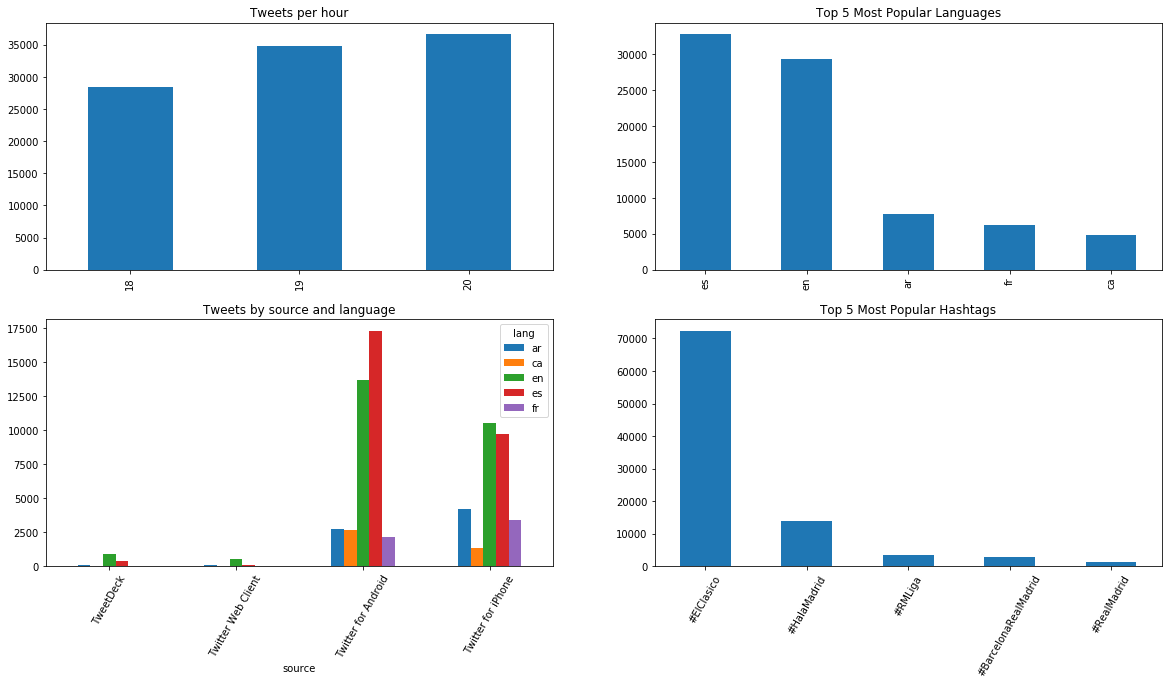

In [21]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(20, 10))

tweets_per_hour.plot(kind="bar",title="Tweets per hour",ax=axes[0,0])

top5_lang.plot(kind="bar",title="Top 5 Most Popular Languages",ax=axes[0,1])

tweets_by_source_lang.plot(kind="bar",title='Tweets by source and language',rot=60,ax=axes[1,0])

top5_hashtags.plot(kind="bar",title='Top 5 Most Popular Hashtags',rot=60,ax=axes[1,1])

En la primera gráfica observamos que, lógicamente, conforme se acerca la hora del partido (20:00) aumenta el número de tweets.

Los tweets se empezaron a recopilar a partir de las 18.17 y el streaming finalizó en 2h y 24 minutos despúes, justo cuando estaba terminando la primera parte del partido (20.45).
Hubiera sido interesante haber recopilado tweets antes, durante y después del partido, sin embargo, al ser un evento tan popular a nivel mundial se alcanzó el límite de tweets muy temprano. Además, en el proceso de streaming no se filtraron retweets ni tampoco idiomas.

Por otro lado, al ser un partido de la liga española, el idioma español es el que tiene mayor número de tweets, incluyendo tanto hispano hablantes como latinos.

Respecto a la fuente desde la cual se publicó el tweet, predomina los móviles con el sistema operativo Android en el idioma español, esto confirma la fuerte presencia de Android en España con una [cuota de mercado superior al 90%](https://es.kantar.com/tech/m%C3%B3vil/2019/abril-2019-cuota-de-mercado-de-smartphones/). 

Por último, el hashtag más popular es #ElClasico, palabra que fue la 2º tendencia más popular a nivel mundial y que se utilizó para captar los tweets durante el streaming.

No obstante, si analizamos el resto de hashtags vemos que el Real Madrid es mencionado 3 veces: #HalaMadrid, #RMLiga, #RealMadrid, luego podemos concluir que hay más aficionados de este equipo por el mundo.

A continuación, vamos a analizar los tweets publicados en español, comprobando la frecuencia con la que aparece cada palabra en el mensaje y mostrándola en una nube de palabras. 

Previamente, será necesario llevar a cabo una pequeña limpieza de los mensajes:

In [22]:
# Filter and add Spanish tweets in a new Pandas Series
tweets_ES=tidy_tweets[tidy_tweets.lang=='es']['text']

In [23]:
# Check duplicate tweets
print(tweets_ES.duplicated().sum())
tweets_ES[tweets_ES.duplicated()].head(10)

19269


38     RT @FCBarcelona_es: El escenario ✨ #ElClasico ...
88     RT @sport: 👑 El Rey #Messi ha llegado\n\n🏟 Cam...
99     RT @FCBarcelona_es: El escenario ✨ #ElClasico ...
103    RT @Iniestismo1899: Si Messi marca en  #ElClas...
106    RT @realmadrid: 📋✅ ¡Nuestro XI inicial 🆚 @FCBa...
108    RT @realmadrid: 📋✅ ¡Nuestro XI inicial 🆚 @FCBa...
110    RT @realmadrid: 📋✅ ¡Nuestro XI inicial 🆚 @FCBa...
113    RT @realmadrid: 📋✅ ¡Nuestro XI inicial 🆚 @FCBa...
115    RT @realmadrid: 📋✅ ¡Nuestro XI inicial 🆚 @FCBa...
117    RT @realmadrid: 📋✅ ¡Nuestro XI inicial 🆚 @FCBa...
Name: text, dtype: object

In [24]:
# Drop duplicate tweets
tweets_ES=tweets_ES.drop_duplicates()
print(tweets_ES.duplicated().sum())

0


In [25]:
tweets_ES.head(10)

1            Se llama tranvía, el metro es subterráneo.
2                           A por ellos 💪💪💪 #HalaMadrid
7     RT @partidazocope: 🔵🔴 ÚLTIMA HORA | El @FCBarc...
10    RT @Zapeander2: .@laSextaTV quitando un espaci...
11         #ElClasico El Real Madrid llegó al Camp Nou.
13    Podrás ser fan o no de alguno de estos 2 equip...
17    RT @danisenabre: NOTICIÓN! INAUDITO. Yo suspen...
19         RT @toxxicz_: Ojalá. https://t.co/Ltg852uUBZ
20    RT @Messi92_FCB: Todos los goles de Messi en #...
22    RT @Informadridista: Buenos recuerdos en el Ca...
Name: text, dtype: object

In [26]:
# Remove URLs, links and twitter handles
for i in range(len(tweets_ES)):
    tweets_ES.iloc[i]= " ".join([word for word in tweets_ES.iloc[i].split()
                              if 'http' not in word and '@' not in word and '<' not in word])

# Remove hashtags
tweets_ES=tweets_ES.str.replace(r'#\w+',"")

# Remove special characters and convert to lowercase
tweets_ES=tweets_ES.apply(lambda x: re.sub('[!@#$:).;,?&-]', '', x.lower()))
tweets_ES=tweets_ES.apply(lambda x: re.sub('  ', ' ', x))

tweets_ES.head(10)

1              se llama tranvía el metro es subterráneo
2                                      a por ellos 💪💪💪 
7     rt 🔵🔴 última hora | el llega al camp nou para ...
10    rt quitando un espacio que tiene más audiencia...
11                     el real madrid llegó al camp nou
13    podrás ser fan o no de alguno de estos 2 equip...
17    rt notición inaudito yo suspendería el partido...
19                                             rt ojalá
20                     rt todos los goles de messi en 😍
22    rt buenos recuerdos en el camp nou rotura de c...
Name: text, dtype: object

Una vez limpiado los tweets, guardamos en una variable de texto (string) los mensajes de cada fila de la serie `tweets_ES`, que utilizaremos para crear nuestra nube de palabras:

In [27]:
text= ' '.join(txt for txt in tweets_ES)
print ('There are {} words in the combination of text rows.'.format(len(text)))

There are 872344 words in the combination of text rows.


A continuación, importamos la librería [wordcloud](https://amueller.github.io/word_cloud/index.html) para generar la nube de palabras. Además, será necesario utilizar la librería [stop_word](https://pypi.org/project/stop-words/) que contiene un diccionario de stop words en español:

In [34]:
from wordcloud import WordCloud
from stop_words import get_stop_words

stop_words=[]

# Get Spanish stop word list
stopwords=get_stop_words('es')

In [35]:
# Add extra words to ignore
stopwords_list=['rt','si','ahora','así','pues','solo','puede','hoy','ver']

for item in stopwords_list:
    stopwords.append(item)

(-0.5, 399.5, 199.5, -0.5)

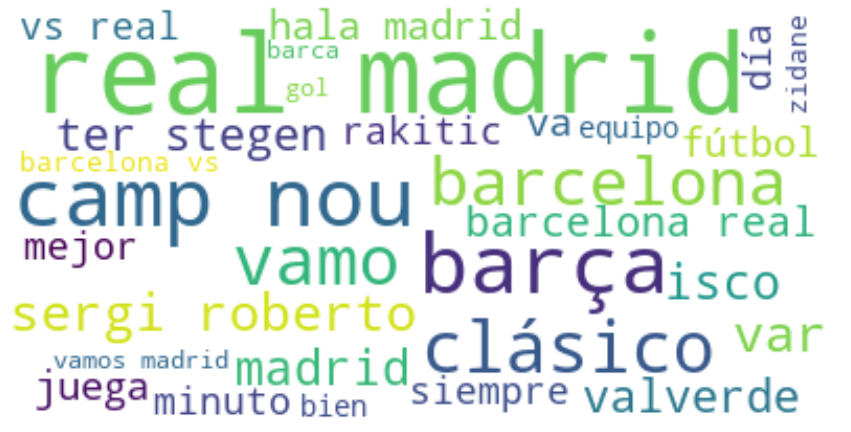

In [36]:
wordcloud=(WordCloud(background_color="white", max_words=30,stopwords=stopwords).generate(text))

plt.figure(figsize=(15,10))

# Show the plot (interpolation='bilinear' makes it better looking)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

### Bibliografía

* https://tweepy.readthedocs.io/en/latest/streaming_how_to.html
* https://shuzhanfan.github.io/2018/03/twitter-streaming-collection/
* https://towardsdatascience.com/jupyter-tools-to-increase-productivity-7b3c6b90be09
* https://developer.twitter.com/en/docs/tweets/filter-realtime/guides/basic-stream-parameters
* https://ronanlopes.me/tweepy-retrieving-trending-topics-twitter-specific-location/
* https://www.eltitular.es/woeid/
* https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/intro-to-tweet-json
* https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html#dt-accessor
* https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object
* https://docs.python.org/3/library/datetime.html#module-datetime
* https://pandas.pydata.org/pandas-docs/version/0.13.1/visualization.html#targeting-different-subplots
* https://stackoverflow.com/